# Gradient descent and Newton's method

(This exercise originates from S. Boyd's course Convex Optimization)

Consider the unconstrained problem
  
  $$\begin{array}{ll}minimize\,\,\, f(x) = - \sum_{i=1}^m \log(1-a_i^T x)- \sum_{i=1}^n \log(1 - x_i^2),\end{array}$$
  
  with variable $x \in \mathbf{R}^n$, and $\mathbf{dom} f = \{x \;|\; a_i^Tx \le 1, ~i=1, \ldots, m, ~|x_i| \le 1, ~i=1, \ldots, n\}$. This is the problem of computing the analytic center of the set of linear inequalities
  
  $$a_i^Tx \leq 1, \quad i=1, \ldots, m, \qquad |x_i|\leq 1,\quad i=1, \ldots, n.$$
 
 Note that we can choose $x^{(0)}=0$ as our initial point. You can generate instances of this problem by choosing $a_i$ from some distribution on $\mathbf{R}^n$.
 

1. Use the gradient descent method to solve the problem. Use backtracking line search (BLS) to choose the step size and a stopping criterion of the form $\| \nabla f(x)\|_2^2 \leq \delta$. You need to choose the parameters $\alpha,\beta$ of BLS as well as $\delta$ in a reasonable way. Plot the objective function and step length versus iteration number. (Once you have determined $p^\star$ to high accuracy, you can also plot $f-p^\star$ versus iteration.) Experiment with the backtracking parameters $\alpha$ and $\beta$ to see their effect on the total number of iterations required. 
2. Repeat using Newton&#39;s method, again with BLS and this time with a stopping criterion based on the square $\lambda^2$ of Newton decrement. Produce the plots as for GD. Can you see the sharp distinction between the areas of slow and fast convergence for the Newton&#39;s method?

Some notes and tips:
* You can find the description of BLS in the slides for the Newton's method lecture. The exact same formulation can be used for GD.
* The domain of the objective is not $\mathbf{R}^n$. So, your BLS needs make sure that the chosen step length results in a point inside the domain (on top of satisfying the standard BLS condition). 
* You are going to have to find formulas for $\nabla f(x)$ and $\nabla^2 f(x)$ by hand using chain rule. If you really want to, you can use pytorch (or other similar tools) for this task, but it is probably not worth it. The GD code and the Newton code has to be your own.
* In the Newton's algorithm do not invert the Hessian, use ``numpy.linalg.solve`` (or other linear system solver) instead.

### Formulas for  $\nabla f(x)$ and $\nabla^2 f(x)$

$$\nabla f(x) = \left( \frac{2x_j}{(1-x_j^2)} + \sum_{i = 0}^{m}\frac{a_{ij}}{1-a_i^T x} \right)_{j=1}^n$$

$$
\displaystyle \nabla^2 f(x) = \left( h_{ij} \right)_{i,j\in\{1,\ldots,n\}} \text{ for } h_{ij} = \begin{cases}
\displaystyle \sum_{k=0}^{m}\frac{a_{ki}a_{kj}}{(1-a_k^Tx)^2},& \text{if } i \neq j\\
\displaystyle 2\frac{1+x_i^2}{(1-x_i^2)^2} + \sum_{k=0}^{m}\frac{a_{ki}^2}{(1-a_k^Tx)^2}, & \text{if } i = j\\
\end{cases}
$$


## Gradient descent
### Parameters $\alpha, \beta$ and $\delta$

I've tested all combinations for $\alpha \in \{0.01, 0.1, 0.3, 0.9\}$ and $\beta \in \{0.1, 0.45, 0.9\}$. I've decided to set $\delta = 10^{-6}$, so the number of iterations in all cases will be smaller than $1000$.

<table>
  <tr>
    <td>alpha \ beta</td>
    <td>0.1</td>
    <td>0.45</td>
    <td>0.9</td>
  </tr>
  <tr>
    <td>0.01</td>
    <td>15</td>
    <td>21</td>
    <td>118</td>
  </tr>
  <tr>
    <td>0.15</td>
    <td>17</td>
    <td>19</td>
    <td>75</td>
  </tr>
  <tr>
    <td>0.3</td>
    <td>17</td>
    <td>15</td>
    <td>17</td>
  </tr>
    <tr>
    <td>0.9</td>
    <td>247</td>
    <td>135</td>
    <td>100</td>
  </tr>
</table>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n, m = 200, 300
A = np.random.rand(m, n)

In [2]:
def objective_function(x, A):
    return -np.sum(np.log(1 - A @ x)) -  np.sum(np.log(1 - np.square(x)))

def gradient(x, A):
    return 2*x / (1 - np.square(x)) + np.sum(A.T / (1 - A @ x), axis=1)

def hessian(x,A):
    return A.T @ np.diag((1.0 / (1- A @ x))**2) @ A + np.diag(2 * (1 + x**2) / (1 - x**2)**2)

In [3]:
def bls(x, alpha, beta, delta_x, A):
    nu = 1
    f_value = objective_function(x,A)
    f_gradient = gradient(x,A)

    # At first we will ensure that we stay in our domain
    while np.max(A@(x + nu * delta_x)) > 1 or np.max(np.abs(x + nu * delta_x)) > 1:
       nu = beta*nu

    # BLS alghorithm
    while objective_function(x + nu * delta_x, A) > f_value + alpha * nu * np.dot(f_gradient, delta_x):
        nu = beta*nu

    return nu

In [38]:
alpha = 0.3
beta = 0.45

In [39]:
def gradient_descent(max_iter=1000, delta=1e-6):
    vals = []
    steps = []
    x = np.zeros(n)
    for i in range(max_iter):
        f_gradient = gradient(x,A)

        # Stopping criterion
        if np.linalg.norm(f_gradient) < delta:
            break
        
        nu = bls(x,alpha, beta, -f_gradient, A)
        vals.append(objective_function(x,A))
        steps.append(nu)
        x = x - nu * f_gradient
    print(f"Number of iterations: {i} with f(x) = {objective_function(x,A)}\n")

    optval = vals[-1]

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(len(vals) - 1), np.array(vals[0:-1]), linestyle='--')
    plt.xlabel('Iteration number')
    plt.ylabel('f(x)')

    plt.subplot(1, 3, 2)
    plt.semilogy(range(len(vals) - 1), np.array(vals[0:-1]) - optval, linestyle='--')
    plt.xlabel('Iteration number')
    plt.ylabel('Step lenght')

    plt.ylabel('f(x) - p*')

    plt.subplot(1, 3, 3)
    plt.plot(range(len(steps)), steps, linestyle='--', marker='o')
    plt.xlabel('Iteration number')
    plt.ylabel('Step lenght')

    plt.tight_layout()
    plt.show()
    return x

Number of iterations: 15 with f(x) = -1147.3938282116956



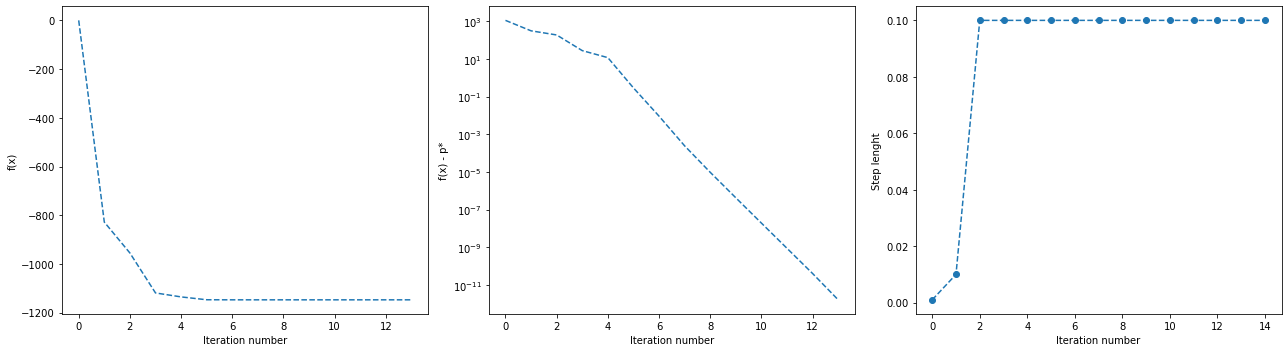

array([-0.65081319, -0.64339411, -0.65376536, -0.64635994, -0.6625436 ,
       -0.62909494, -0.65054751, -0.65833019, -0.66255167, -0.63986114,
       -0.65326432, -0.66223413, -0.64195775, -0.67550369, -0.64360966,
       -0.65222643, -0.65926595, -0.64959446, -0.65179955, -0.65657204,
       -0.63880069, -0.65136947, -0.64775974, -0.6519197 , -0.65222902,
       -0.64808179, -0.65961341, -0.65173771, -0.64859754, -0.64876248,
       -0.66338921, -0.65735702, -0.66624607, -0.65242034, -0.64985708,
       -0.66034102, -0.66382837, -0.65395019, -0.67171804, -0.64442908,
       -0.64389794, -0.65007012, -0.63706276, -0.65544871, -0.65176242,
       -0.64124723, -0.64856618, -0.6649385 , -0.64777035, -0.66328833,
       -0.65290144, -0.65680138, -0.65596648, -0.66397856, -0.65721354,
       -0.65151471, -0.64093989, -0.66244257, -0.6479258 , -0.64242564,
       -0.65319765, -0.66114784, -0.65600616, -0.63978984, -0.66326632,
       -0.65369625, -0.63834713, -0.64298597, -0.64358614, -0.65

In [40]:
gradient_descent()

## Newton's method
### Parameters $\alpha, \beta$ and $\delta$
form
I've tested all combinations for $\alpha \in \{0.01, 0.1, 0.3, 0.9\}$ and $\beta \in \{0.1, 0.45, 0.9\}$. I've decided to set $\delta = 10^{-10}$  for similar reasons as before.

<table>
  <tr>
    <td>alpha \ beta</td>
    <td>0.1</td>
    <td>0.45</td>
    <td>0.9</td>
  </tr>
  <tr>
    <td>0.01</td>
    <td>9</td>
    <td>9</td>
    <td>9</td>
  </tr>
  <tr>
    <td>0.15</td>
    <td>9</td>
    <td>9</td>
    <td>9</td>
  </tr>
  <tr>
    <td>0.3</td>
    <td>9</td>
    <td>9</td>
    <td>9</td>
  </tr>
    <tr>
    <td>0.9</td>
    <td>174</td>
    <td>161</td>
    <td>88</td>
  </tr>
</table>

In [76]:
alpha = 0.01
beta = 0.9

In [77]:
def newtons_method(max_iter=1000, delta=1e-10):
    vals_newton = []
    steps_newton = []
    x = np.zeros(n)
    for i in range(max_iter):
        f_gradient = gradient(x,A)
        delta_x = np.linalg.solve(hessian(x,A), f_gradient)

        # Stopping criterion lambda^2 < delta
        if f_gradient.T @ delta_x < delta:
            break

        nu = bls(x,alpha, beta, -delta_x, A)
        vals_newton.append(objective_function(x,A))
        steps_newton.append(nu)
        x = x - nu * delta_x
    print(f"Last iteration: {i} with f(x) = {objective_function(x,A)}\n")

    optval = vals_newton[-1]

    plt.figure(figsize=(18,5))

    plt.subplot(1, 3, 1)
    plt.plot(range(len(vals_newton) - 1), np.array(vals_newton[0:-1]), linestyle='--')
    plt.xlabel('Iteration number')
    plt.ylabel('f(x)')

    plt.subplot(1, 3, 2)
    plt.semilogy(range(len(vals_newton) - 1), np.array(vals_newton[0:-1]) - optval, linestyle='--')
    plt.xlabel('Iteration number')
    plt.ylabel('f(x) - p*')

    plt.subplot(1, 3, 3)
    plt.plot(range(len(steps_newton)), steps_newton, linestyle='--', marker='o')
    plt.xlabel('Iteration number')
    plt.ylabel('Step lenght')

    plt.show()
    return x

Last iteration: 9 with f(x) = -1147.3938282116953



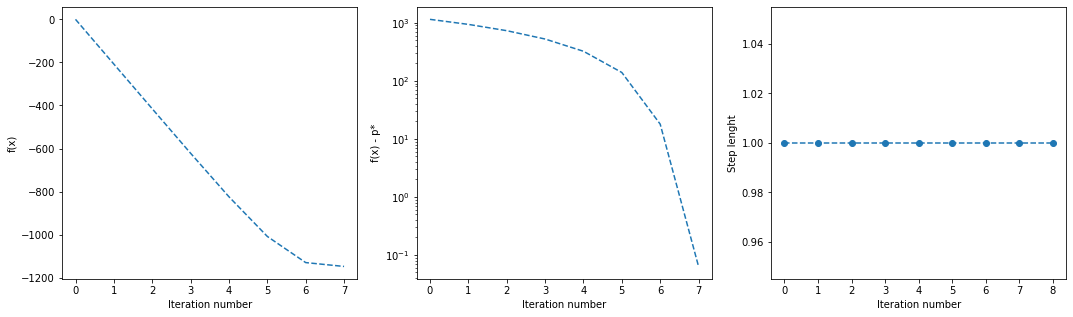

array([-0.6508132 , -0.64339413, -0.65376537, -0.64635995, -0.66254361,
       -0.62909495, -0.65054752, -0.6583302 , -0.66255168, -0.63986115,
       -0.65326432, -0.66223413, -0.64195776, -0.67550369, -0.64360967,
       -0.65222644, -0.65926596, -0.64959447, -0.65179956, -0.65657204,
       -0.63880071, -0.65136948, -0.64775975, -0.65191971, -0.65222903,
       -0.6480818 , -0.65961341, -0.65173772, -0.64859755, -0.64876249,
       -0.66338922, -0.65735703, -0.66624607, -0.65242035, -0.64985709,
       -0.66034102, -0.66382837, -0.65395019, -0.67171804, -0.64442909,
       -0.64389796, -0.65007013, -0.63706277, -0.65544872, -0.65176243,
       -0.64124724, -0.64856619, -0.6649385 , -0.64777036, -0.66328834,
       -0.65290145, -0.65680139, -0.65596649, -0.66397857, -0.65721354,
       -0.65151472, -0.6409399 , -0.66244257, -0.64792581, -0.64242565,
       -0.65319765, -0.66114785, -0.65600618, -0.63978986, -0.66326632,
       -0.65369626, -0.63834715, -0.64298598, -0.64358615, -0.65

In [78]:
newtons_method()

### Conclusion on Convergence Behavior of Newton's Algorithm

In the middle plot (Logarithmic Scale of $(f-p^\star)$ vs. Iteration Number), the decrease in $(f-p^\star)$ during the initial iterations (0 to 3) is relatively gradual, indicating a slow convergence phase. Starting around iteration 4, there is a noticeable change in the slope, with a rapid decrease in $(f-p^\star)$. This signifies a transition to the fast convergence phase.

Moreover, the step length being consistently equal to $1$ suggests that the algorithm is likely in the pure Newton phase.